In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import cshl_project as cshl
from tqdm import tqdm

## Replicating

In [2]:
def relu(x):
    """rectified linear unit"""
    if isinstance(x, np.ndarray):
        y = np.array(x)
        y[y < 0] = 0
        return y
    else: # it should be a builtin number type (int or float)
        return 0 if x < 0 else x

In [3]:
class LGNnode(object):
    """LN model for LGN subunits
    
    This class will calculate the response to sinusoidal grating and plaid given
    by the stimulus orientation (in rad), phase (in rad), contrast ([0, 1]), etc.
    Instead of spatial convolution, the LGN subunit will be represented as a point.
    
    Parameters:
    - `center`: the center location [default: np.array([0, 0])]
    - `nonlinear`: the nonlinear function [default: relu]
    - `Rmax`: the maximum firing rate [default: 11.3]
    - `C50`: contrast level for 50% response [default: 0.5]
    - `Rbase`: background response [default: 0]
    
    Public Methods:
    - `get_response_grating`
    - `get_response_plaid`
    
    Private Methods:
    - `_get_contrast_response`
    - `_get_sinusoidal`
    - `_get_sinusoidal_plaid`
    
    """
    def __init__(self, center=(0, 0), nl=relu, Rmax=11.3, C50=0.5, Rbase=0):
        """Constructor of `LGNnode` class
        
        Keyword Arguments:
        - center: `tuple{real, real}` location of this subunit [default: (0, 0), arbitrary unit (e.g. pixel)]
        - nl: `function` nonlinearity function [default: relu]
        - Rmax: [default: 11.3] refer to `LGNnode._get_contrast_response` for full documentation.
        - C50: [default: 0.5] refer to `LGNnode._get_contrast_response` for full documentation.
        - Rbase: [default: 0] refer to `LGNnode._get_contrast_response` for full documentation.
        """
        super(LGNnode, self).__init__()
        
        self.center = np.array(center).reshape((2, 1))
        self.nonlinear = nl
        
        self.Rmax = Rmax
        self.C50 = C50
        self.Rbase = Rbase
        
    def _get_contrast_response(self, contrast, order=1):
        """Contrast response function
        
        Nonlinear map from contrast level to response (e.g., firing rate).
        
        .. math::
            R(c) = R_{\\text{max}} \\frac{c^\\alpha}{c^\\alpha + c_{50}^\\alpha} + R_{\\text{base}}
            
        Arguments:
        - contrast: `real` contrast level ranging from 0 to 1
        
        Keyword Arguments:
        - order: `real` the power of the function [default: 1]
        
        Inherited Arguments:
        - self.Rmax: the maximum response [default: 11.3]
        - self.C50: the contrast level for half of the maximum response [default: 0.5]
        - self.Rbase: the spontaneous/background response [default: 0]
        """
        return self.Rmax * contrast ** order / (contrast ** order + self.C50 ** order) + self.Rbase
    
    def _get_sinusoidal(self, ori=0, contrast=0.48, phase=0, sf=50):
        """return the luminance and contrast level given grating parameters.
        Refer to `LGNnode.get_response_grating` for full documentation.
        """
        _dist_ϕ = np.array([[np.cos(ori), np.sin(ori)]]) @ self.center / sf * 2 * np.pi
        _luminance = np.sin(_dist_ϕ[0][0] + phase)
        return _luminance * 2, contrast
    
    #XXX: check
    # def _get_sinusoidal_plaid(self, ori1=0, ori2=0, contrast1=0.48, contrast2=0.48, phase=0, Δphase=0, sf=50):
    #     _l1, _c1 = self._get_sinusoidal(ori1, contrast1, phase, sf)
    #     _l2, _c2 = self._get_sinusoidal(ori2, contrast2, phase-Δphase, sf)
    #     return (_l1+_l2) / 2, (_c1+_c2)
    
    def _get_sinusoidal_plaid(self, ori1=0, ori2=0, contrast1=0.48, contrast2=0.48, phase=0, Δphase=0, sf=50):
        """return the luminance and contrast level given plaid parameters.
        Refer to `LGNnode.get_response_plaid` for full documentation.
        """
        _dist_ϕ_1 = np.array([[np.cos(ori1), np.sin(ori1)]]) @ self.center / sf * 2 * np.pi
        _dist_ϕ_2 = np.array([[np.cos(ori2), np.sin(ori2)]]) @ self.center / sf * 2 * np.pi + Δphase
        
        _vec = contrast1 * np.exp(_dist_ϕ_1[0][0] * 1j) + contrast2 * np.exp(_dist_ϕ_2[0][0] * 1j)
        _luminance = np.sin(np.angle(_vec) + phase)

        return _luminance * 2, np.abs(_vec)
    
    def get_response_grating(self, *args, **kwargs):
        """calculate the linear-nonlinear response of subunit to sinusoidal grating stimulus.
        
        #TODO: formula to calculate the phase and contrast level.
        
        Keyword Arguments:
        - ori: orientation in rad [default: 0]
        - contrast: contrast level in [0, 1] [default: 0.48]
        - phase: `real` or `numpy.ndarray` phase in rad [default: 0]
        - sf: spatial frequency in arbitrary unit per cycle [default: 50]
        """
        _l, _c = self._get_sinusoidal(*args, **kwargs)
        return self.nonlinear(self._get_contrast_response(_c) * _l)
    
    def get_response_plaid(self, *args, **kwargs):
        """calculate the linear-nonlinear response of subunit to sinusoidal plaid stimulus.
        
        #TODO: formula to calculate the phase and contrast level.
        
        Keyword Arguments:
        - ori1: primary orientation in rad [default: 0]
        - ori2: secondary orientation in rad [default: 0]
        - contrast1: primary contrast level in [0, 1] [default: 0.48]
        - contrast2: secondary contrast level in [0, 1] [default: 0.48]
        - phase: `real` or `numpy.ndarray` phase in rad [default: 0]
        - Δphase: phase offset of secondary grating [default: 0]
        - sf: spatial frequency in arbitrary unit per cycle [default: 50]
        """
        _l, _c = self._get_sinusoidal_plaid(*args, **kwargs)
        return self.nonlinear(self._get_contrast_response(_c) * _l)

In [4]:
class V1node(object):
    """LN model for V1 neuron
    
    This class will group a list of LGNnode and process the convergent inputs from LGN subunits.
    
    Parameters:
    - `subunits`: list of `LGNunit`s [default: []]
    - `nonlinear`: the nonlinear function [default: relu]
    
    Public Methods:
    - `get_response_grating`
    - `get_response_plaid`
    """
    def __init__(self, subunits=[], nl=relu):
        """Constructor of `V1node` class
        
        Keyword Arguments:
        - subunits: list of `LGNnode`s [default: []]
        - nl: `function` nonlinearity function [default: relu]
        """
        super(V1node, self).__init__()
        self.subunits = subunits
        self.nonlinear = nl
            
    def get_response_grating(self, length=720, phase=0, **kwargs):
        """LN resposne to the convergent inputs from LGN subunits to sinusoidal grating stimulus.
        
        Return the response of one full cycle of grating stimulus given parameters.
        
        Keyword Arguments:
        - length: `int` total steps for simulating the full cycle [default: 720]
        - phase: `real` the initial phase value [default: 0]
        - **kwargs: refer to `LGNnode.get_response_grating` for full documentation.
        """
        _resp = np.zeros(length)
        _step = np.linspace(0, 2*np.pi*(1-1/length), length)
        for item in self.subunits:
            _resp += item.get_response_grating(phase=_step+phase, **kwargs)
        return _resp / len(self.subunits)
    
    def get_response_plaid(self, length=720, phase=0, **kwargs):
        """LN resposne to the convergent inputs from LGN subunits to sinusoidal plaid stimulus.
        
        Return the response of one full cycle of plaid stimulus given parameters.
        
        Keyword Arguments:
        - length: `int` total steps for simulating the full cycle [default: 720]
        - phase: `real` the initial phase value [default: 0]
        - **kwargs: refer to `LGNnode.get_response_grating` for full documentation.
        """
        _resp = np.zeros(length)
        _step = np.linspace(0, 2*np.pi*(1-1/length), length)
        for item in self.subunits:
            _resp += item.get_response_plaid(phase=_step+phase, **kwargs)
        return _resp / len(self.subunits)

In [5]:
class IndexCalc(object):
    """Static class for various indices.
    
    Available Methods:
    - `masking_index`
    - `selectivity_index`
    - `F1_modulation`
    """
    @staticmethod
    def masking_index(test, mask, plaid):
        """Masking index defined as:
        
        .. math::
            \\text{MI} = \\frac{\\text{Plaid} - (\\text{Test} + \\text{Mask})}{\\text{Plaid} + (\\text{Test} + \\text{Mask})}
        """
        _r = test + mask
        return (plaid - _r) / (plaid + _r)
    
    @staticmethod
    def selectivity_index(test, mask):
        """Selectivity index defined as:
        
        .. math::
            \\text{SI} = \\frac{\\text{Test} - \\text{Mask}}{\\text{Test} + \\text{Mask}}
        """
        return (test - mask) / (test + mask)
    
    @staticmethod
    def F1_modulation(response, reference=None):
        """F1 modulation component using Fourier transform."""
        if reference is None:
            return np.abs(np.fft.fft(response))[1] / len(response) * 2
        else:
            return IndexCalc.F1_modulation(response) / IndexCalc.F1_modulation(reference)


---
## reproducing the results

|SI|offset(degree)|
|--|:----:|
|1 |45    |
|.7|38    |
|.25|24|
|0|0|

_gaps = [45, 42, 38, 34, 30, 24, 0]

### Figure 4 D

<img src="./reading/matlab/fig4-1.png" width="50%" height="50%" alt="not found"/>

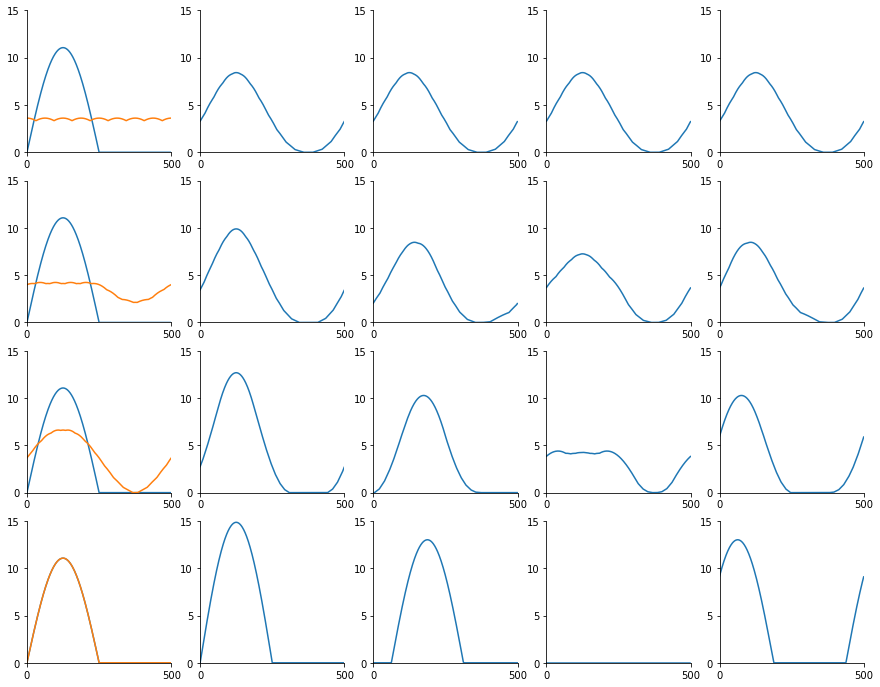

In [47]:
fig, axes = plt.subplots(4, 5)
fig.set_size_inches(15, 12)

for m_idx, subunit_gap_deg in enumerate([45, 38, 24, 0]):
    _v1_model = V1node(subunits=[
        LGNnode(center=((idx-3.5) * 50 * (subunit_gap_deg / 360), 0)) for idx in range(8)
    ])
    
    _test_resp = _v1_model.get_response_grating(length=500, ori=np.deg2rad(90))
    _mask_resp = _v1_model.get_response_grating(length=500, ori=np.deg2rad(0))
    axes[m_idx, 0].plot(_test_resp)
    axes[m_idx, 0].plot(_mask_resp)
    # styling
    axes[m_idx, 0].spines.right.set_visible(False)
    axes[m_idx, 0].spines.top.set_visible(False)
    axes[m_idx, 0].set_xlim((0, 500))
    axes[m_idx, 0].set_ylim((0, 15))
    axes[m_idx, 0].set_xticks([0, 500])
    axes[m_idx, 0].set_yticks([0, 5, 10, 15])
    
    for ϕ_idx, _phase_offset in enumerate([0, 90, 180, 270]):
        _plaid_resp = _v1_model.get_response_plaid(length=500, ori1=np.deg2rad(90), ori2=np.deg2rad(0), Δphase=-np.deg2rad(_phase_offset))
        axes[m_idx, 1+ϕ_idx].plot(_plaid_resp)
        # styling
        axes[m_idx, 1+ϕ_idx].spines.right.set_visible(False)
        axes[m_idx, 1+ϕ_idx].spines.top.set_visible(False)
        axes[m_idx, 1+ϕ_idx].set_xlim((0, 500))
        axes[m_idx, 1+ϕ_idx].set_ylim((0, 15))
        axes[m_idx, 1+ϕ_idx].set_xticks([0, 500])
        axes[m_idx, 1+ϕ_idx].set_yticks([0, 5, 10, 15])

fig;

### Figure 4 EF

<img src="./reading/matlab/fig4-2.png" width="60%" height="60%" alt="not found"/>

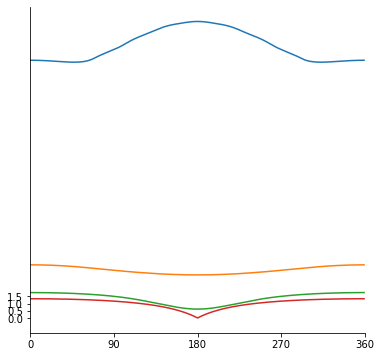

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

for m_idx, subunit_gap_deg in enumerate([45, 38, 24, 0]):
    _v1_model = V1node(subunits=[
        LGNnode(center=((idx-3.5) * 50 * (subunit_gap_deg / 360), 0)) for idx in range(8)
    ])
    
    _test_resp = _v1_model.get_response_grating(length=720, ori=np.deg2rad(15))
    _norm_resp_amp = []
    for mask_phase_offset in range(360):
        _full_resp = _v1_model.get_response_plaid(length=720, ori1=np.deg2rad(15), ori2=np.deg2rad(15-90), Δphase=-np.deg2rad(mask_phase_offset))
        _index_val = IndexCalc.F1_modulation(_full_resp, _test_resp)
        _norm_resp_amp.append(_index_val)
        
    ax.plot(_norm_resp_amp)
    
# styling
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim((0, 360))
# ax.set_ylim((0, 1.5))
ax.set_xticks([0, 90, 180, 270, 360])
# ax.set_xticks([0, 90, 180, 270, 360],['0', '$\\frac{1}{2} \\pi$', '$\\pi$', '$\\frac{3}{2} \\pi$', '$2\\pi$'])
ax.set_yticks([0, 0.5, 1.0, 1.5])
fig;

''

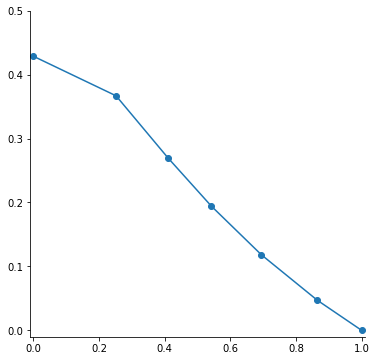

In [68]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

_SI = []
_PMI = []

for m_idx, subunit_gap_deg in enumerate([45, 42, 38, 34, 30, 24, 0]):
    _v1_model = V1node(subunits=[
        LGNnode(center=((idx-3.5) * 50 * (subunit_gap_deg / 360), 0)) for idx in range(8)
    ])
    
    _test_resp = _v1_model.get_response_grating(length=720, ori=np.deg2rad(90))
    _mask_resp = _v1_model.get_response_grating(length=720, ori=np.deg2rad(0))
    
    _norm_amp_item = []
    for mask_phase_offset in range(360):
        _full_resp = _v1_model.get_response_plaid(length=720, ori1=np.deg2rad(90), ori2=np.deg2rad(0), Δphase=-np.deg2rad(mask_phase_offset))
        _index_val = IndexCalc.F1_modulation(_full_resp, _test_resp)
        _norm_amp_item.append(_index_val)
    
    _SI.append(IndexCalc.selectivity_index(
        IndexCalc.F1_modulation(_test_resp), IndexCalc.F1_modulation(_mask_resp)))
    
    _PMI.append(IndexCalc.F1_modulation(np.array(_norm_amp_item)))
    
ax.plot(_SI, _PMI)
ax.scatter(_SI, _PMI)
# styling
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim((-0.01, 1.01))
ax.set_ylim((-0.01, 0.5))
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# ax.set_xticks([0, 90, 180, 270, 360],['0', '$\\frac{1}{2} \\pi$', '$\\pi$', '$\\frac{3}{2} \\pi$', '$2\\pi$'])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
;